In [149]:
#Import Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Dense,Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing,metrics

In [150]:
#Reading the datasets into pandas
stock_price=pd.read_csv("Downloads/AAPL.csv")
stock_headlines=pd.read_csv("Downloads/india-news-headlines.csv")

In [151]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-06-05,80.837502,82.937500,80.807503,82.875000,82.320328,137250400
1,2020-06-08,82.562500,83.400002,81.830002,83.364998,82.807037,95654400
2,2020-06-09,83.035004,86.402496,83.002502,85.997498,85.421921,147712400
3,2020-06-10,86.974998,88.692497,86.522499,88.209999,87.619614,166651600
4,2020-06-11,87.327499,87.764999,83.870003,83.974998,83.412964,201662400


In [152]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


# Feature Engineering

In [153]:
len(stock_price),len(stock_headlines)

(252, 3424067)

In [154]:
#Checking out null values in both datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [155]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-06-05,82.875000,80.837502,82.937500,80.807503,137250400
2020-06-08,83.364998,82.562500,83.400002,81.830002,95654400
2020-06-09,85.997498,83.035004,86.402496,83.002502,147712400
2020-06-10,88.209999,86.974998,88.692497,86.522499,166651600
2020-06-11,83.974998,87.327499,87.764999,83.870003,201662400
...,...,...,...,...,...
2021-05-28,124.610001,125.570000,125.800003,124.550003,71311100
2021-06-01,124.279999,125.080002,125.349998,123.940002,67637100
2021-06-02,125.059998,124.279999,125.239998,124.050003,59278900


In [156]:
#Stock News Headline

In [157]:
stock_headlines.drop_duplicates()

#Converting the datatype of column "Date" from type string to type 'Dateline'

stock_headlines['publish_date']=stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

#Filtering the important columns required
stock_headlines=stock_headlines.filter(['publish_date','headline_text'])

stock_headlines=stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x:','.join(x)).reset_index()

stock_headlines.set_index('publish_date',inplace=True)

stock_headlines=stock_headlines.sort_index(ascending=True,axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [158]:
#Combining Stock and headline data

In [159]:
stock_data=pd.concat([stock_price,stock_headlines],axis=1)
stock_data.dropna(axis=0,inplace=True)
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-06-05,82.875000,80.837502,82.937500,80.807503,137250400.0,"Woman electrocuted in Deolali Camp,World Envir..."
2020-06-08,83.364998,82.562500,83.400002,81.830002,95654400.0,"DK KSRTC loses Rs 86 cr during lockdown,Vasco ..."
2020-06-09,85.997498,83.035004,86.402496,83.002502,147712400.0,"New library with 49k books opens in Madikeri,6..."
2020-06-10,88.209999,86.974998,88.692497,86.522499,166651600.0,Wearing PPE kits can be cumbersome; but custom...
2020-06-11,83.974998,87.327499,87.764999,83.870003,201662400.0,"Barbers at Kashi ghats hope for biz revival,Pa..."
...,...,...,...,...,...,...
2020-12-24,131.970001,131.320007,133.460007,131.100006,54930100.0,How to set the mood for sex during cold winter...
2020-12-28,136.690002,133.990005,137.339996,133.509995,124486200.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,134.869995,138.050003,138.789993,134.339996,121047300.0,Man recovers charred remains of 'thief' from h...
2020-12-30,133.720001,135.580002,135.990005,133.399994,96452100.0,Numerology Readings 30 December 2020: Predicti...


In [160]:
#Calculating sentiment Scores

In [161]:
#Adding empty columns to stack_data for later calculation
stock_data['compound']=''
stock_data['neagtive']=''
stock_data['neutral']=''
stock_data['positive']=''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,neagtive,neutral,positive
2020-06-05,82.875000,80.837502,82.937500,80.807503,137250400.0,"Woman electrocuted in Deolali Camp,World Envir...",,,,
2020-06-08,83.364998,82.562500,83.400002,81.830002,95654400.0,"DK KSRTC loses Rs 86 cr during lockdown,Vasco ...",,,,
2020-06-09,85.997498,83.035004,86.402496,83.002502,147712400.0,"New library with 49k books opens in Madikeri,6...",,,,
2020-06-10,88.209999,86.974998,88.692497,86.522499,166651600.0,Wearing PPE kits can be cumbersome; but custom...,,,,
2020-06-11,83.974998,87.327499,87.764999,83.870003,201662400.0,"Barbers at Kashi ghats hope for biz revival,Pa...",,,,


In [162]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,neagtive,neutral,positive,negative
2020-06-05,82.875000,80.837502,82.937500,80.807503,137250400.0,"Woman electrocuted in Deolali Camp,World Envir...",-0.9998,,0.787,0.083,0.130
2020-06-08,83.364998,82.562500,83.400002,81.830002,95654400.0,"DK KSRTC loses Rs 86 cr during lockdown,Vasco ...",-0.9996,,0.785,0.087,0.128
2020-06-09,85.997498,83.035004,86.402496,83.002502,147712400.0,"New library with 49k books opens in Madikeri,6...",-0.9997,,0.813,0.070,0.117
2020-06-10,88.209999,86.974998,88.692497,86.522499,166651600.0,Wearing PPE kits can be cumbersome; but custom...,-0.9997,,0.752,0.105,0.142
2020-06-11,83.974998,87.327499,87.764999,83.870003,201662400.0,"Barbers at Kashi ghats hope for biz revival,Pa...",-0.9985,,0.866,0.052,0.082


# Finalizing Stock Data and writing to Disk

In [163]:

# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()


,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-06-05,82.875000,-0.9998,0.130,0.787,0.083,80.837502,82.937500,80.807503,137250400.0
2020-06-08,83.364998,-0.9996,0.128,0.785,0.087,82.562500,83.400002,81.830002,95654400.0
2020-06-09,85.997498,-0.9997,0.117,0.813,0.070,83.035004,86.402496,83.002502,147712400.0
2020-06-10,88.209999,-0.9997,0.142,0.752,0.105,86.974998,88.692497,86.522499,166651600.0
2020-06-11,83.974998,-0.9985,0.082,0.866,0.052,87.327499,87.764999,83.870003,201662400.0


In [164]:
stock_data.to_csv('stock_data.csv')

# Reading Stock Data

In [165]:
stock_data=pd.read_csv('stock_data.csv',index_col=False)
stock_data.rename(columns={"Unnamed: 0": 'Date'},inplace=True)
stock_data.set_index('Date',inplace=True)
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-06-05,82.875000,-0.9998,0.130,0.787,0.083,80.837502,82.937500,80.807503,137250400.0
2020-06-08,83.364998,-0.9996,0.128,0.785,0.087,82.562500,83.400002,81.830002,95654400.0
2020-06-09,85.997498,-0.9997,0.117,0.813,0.070,83.035004,86.402496,83.002502,147712400.0
2020-06-10,88.209999,-0.9997,0.142,0.752,0.105,86.974998,88.692497,86.522499,166651600.0
2020-06-11,83.974998,-0.9985,0.082,0.866,0.052,87.327499,87.764999,83.870003,201662400.0


# Feature Engineering of Stock Data

In [166]:
stock_data.shape

(146, 9)

In [167]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [168]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,1.460000e+02
mean,111.370959,-0.985943,0.126747,0.795466,0.077760,111.409949,112.917414,109.731609,1.451946e+08
std,13.503355,0.165275,0.016968,0.024156,0.012045,13.736589,13.797919,13.327244,5.939597e+07
min,82.875000,-0.999900,0.082000,0.742000,0.047000,80.837502,82.937500,80.807503,4.669130e+07
25%,97.385624,-0.999800,0.116250,0.781250,0.069000,97.696249,99.248123,96.518124,1.022816e+08
50%,115.025002,-0.999800,0.127000,0.791500,0.078000,114.920002,116.260002,113.297501,1.330456e+08
75%,120.607500,-0.999600,0.137750,0.812250,0.084000,120.067499,121.879999,118.749998,1.759733e+08
max,136.690002,0.997400,0.169000,0.866000,0.127000,138.050003,138.789993,134.339996,3.743368e+08


In [169]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 2020-06-05 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     146 non-null    float64
 1   compound  146 non-null    float64
 2   negative  146 non-null    float64
 3   neutral   146 non-null    float64
 4   positive  146 non-null    float64
 5   Open      146 non-null    float64
 6   High      146 non-null    float64
 7   Low       146 non-null    float64
 8   Volume    146 non-null    float64
dtypes: float64(9)
memory usage: 11.4+ KB


# Plotting of Stock Data

Text(0, 0.5, 'Close Price($)')

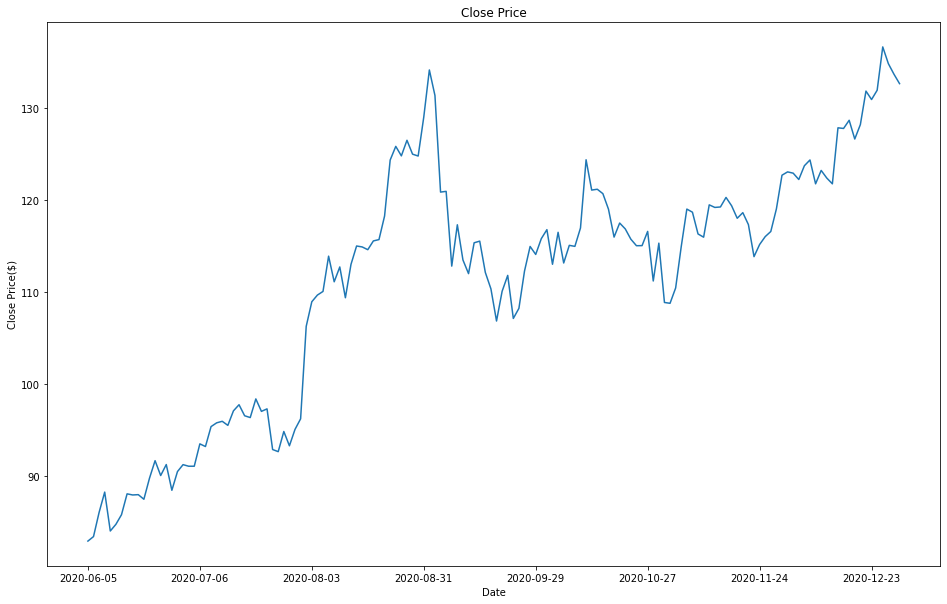

In [170]:
plt.figure(figsize=(16,10))
stock_data['Close'].plot()
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel("Close Price($)")

In [171]:
#Calculating 7 Day Rolling Mean
stock_data.rolling(7).mean().head(10)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-15,84.981427,-0.999543,0.121714,0.800000,0.078000,84.318572,86.081070,83.247501,1.554123e+08
2020-06-16,85.716426,-0.999543,0.123143,0.797571,0.079000,85.322500,86.847142,84.015000,1.594378e+08
2020-06-17,86.363927,-0.999386,0.120571,0.800000,0.079143,86.211785,87.625713,84.863929,1.621166e+08


<AxesSubplot:xlabel='Date'>

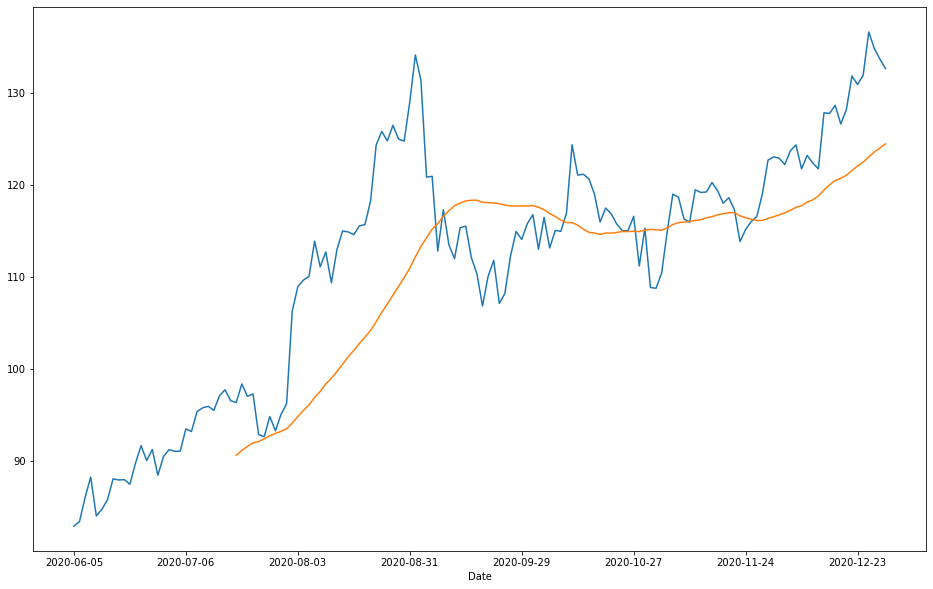

In [172]:
plt.figure(figsize=(16,10))

stock_data["Close"].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [173]:
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-06-05,82.875000,-0.9998,0.130,0.787,0.083,80.837502,82.937500,80.807503,137250400.0
2020-06-08,83.364998,-0.9996,0.128,0.785,0.087,82.562500,83.400002,81.830002,95654400.0
2020-06-09,85.997498,-0.9997,0.117,0.813,0.070,83.035004,86.402496,83.002502,147712400.0
2020-06-10,88.209999,-0.9997,0.142,0.752,0.105,86.974998,88.692497,86.522499,166651600.0
2020-06-11,83.974998,-0.9985,0.082,0.866,0.052,87.327499,87.764999,83.870003,201662400.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,131.970001,-0.9971,0.082,0.854,0.064,131.320007,133.460007,131.100006,54930100.0
2020-12-28,136.690002,-0.9997,0.126,0.790,0.084,133.990005,137.339996,133.509995,124486200.0
2020-12-29,134.869995,-0.9998,0.136,0.774,0.090,138.050003,138.789993,134.339996,121047300.0


# Preparation for Modelling

In [174]:
percentage_of_data=1.0
data_to_use=int(percentage_of_data*(len(stock_data)-1))

train_end=int(data_to_use*0.8)
total_data=len(stock_data)
start=total_data-data_to_use

print("Number of records in Training Data:",train_end)
print("Number of records in Testing Data:",total_data-train_end)

Number of records in Training Data: 116
Number of records in Testing Data: 30


In [175]:
steps_to_predict=1

#Capturing Data to be used for each column
close_price=stock_data.iloc[start:total_data,0]
compound=stock_data.iloc[start:total_data,1]
negative = stock_data.iloc[start:total_data,2] 
neutral = stock_data.iloc[start:total_data,3] 
positive = stock_data.iloc[start:total_data,4] 
open_price = stock_data.iloc[start:total_data,5] 
high = stock_data.iloc[start:total_data,6]
low = stock_data.iloc[start:total_data,7] 
volume = stock_data.iloc[start:total_data,8] 

print("Close price:")
close_price

Close price:


Date
2020-06-08     83.364998
2020-06-09     85.997498
2020-06-10     88.209999
2020-06-11     83.974998
2020-06-12     84.699997
                 ...    
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
2020-12-30    133.720001
2020-12-31    132.690002
Name: Close, Length: 145, dtype: float64

In [176]:
#Shifting Next Day Close

close_price_shifted=close_price.shift(-1)

#Shifting Next Day Compund
compound_shifted=compound.shift(-1)

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

#Revised columns Names
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

#Dropping Nulls
data=data.dropna()
data.head()

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2020-06-08,83.364998,85.997498,-0.9996,-0.9997,95654400.0,82.562500,83.400002,81.830002
2020-06-09,85.997498,88.209999,-0.9997,-0.9997,147712400.0,83.035004,86.402496,83.002502
2020-06-10,88.209999,83.974998,-0.9997,-0.9985,166651600.0,86.974998,88.692497,86.522499
2020-06-11,83.974998,84.699997,-0.9985,-0.9998,201662400.0,87.327499,87.764999,83.870003
2020-06-12,84.699997,85.747498,-0.9998,-0.9997,200146000.0,86.180000,86.949997,83.555000


# Setting The Target Variable and the Feature Dataset

In [177]:
y=data['close_price_shifted']
y

Date
2020-06-08     85.997498
2020-06-09     88.209999
2020-06-10     83.974998
2020-06-11     84.699997
2020-06-12     85.747498
                 ...    
2020-12-23    131.970001
2020-12-24    136.690002
2020-12-28    134.869995
2020-12-29    133.720001
2020-12-30    132.690002
Name: close_price_shifted, Length: 144, dtype: float64

In [178]:
cols=['close_price','compound','compound_shifted','volume','open_price','high','low']
x=data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2020-06-08,83.364998,-0.9996,-0.9997,95654400.0,82.562500,83.400002,81.830002
2020-06-09,85.997498,-0.9997,-0.9997,147712400.0,83.035004,86.402496,83.002502
2020-06-10,88.209999,-0.9997,-0.9985,166651600.0,86.974998,88.692497,86.522499
2020-06-11,83.974998,-0.9985,-0.9998,201662400.0,87.327499,87.764999,83.870003
2020-06-12,84.699997,-0.9998,-0.9997,200146000.0,86.180000,86.949997,83.555000
...,...,...,...,...,...,...,...
2020-12-23,130.960007,-0.9996,-0.9971,88223700.0,132.160004,132.429993,130.779999
2020-12-24,131.970001,-0.9971,-0.9997,54930100.0,131.320007,133.460007,131.100006
2020-12-28,136.690002,-0.9997,-0.9998,124486200.0,133.990005,137.339996,133.509995


In [179]:
#Scaling

In [180]:
X_scaler=preprocessing.MinMaxScaler(feature_range=(-1,1))
X=np.array(x).reshape(len(x),len(cols))
X=X_scaler.fit_transform(x)

X

array([[-1.        , -0.99969959, -0.99979973, ..., -1.        ,
        -1.        , -1.        ],
       [-0.90126583, -0.99979973, -0.99979973, ..., -0.98296899,
        -0.89158713, -0.95534183],
       [-0.81828408, -0.99979973, -0.99859811, ..., -0.84095525,
        -0.80890067, -0.82127223],
       ...,
       [ 1.        , -0.99979973, -0.99989986, ...,  0.85366081,
         0.94764408,  0.96838693],
       [ 0.93173908, -0.99989986, -0.99989986, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.88860757, -0.99989986, -0.99969959, ...,  0.91097091,
         0.89889914,  0.96419722]])

In [181]:
y_scaler=preprocessing.MinMaxScaler(feature_range=(-1,1))
y=np.array(y).reshape((len(y),1))
y=y_scaler.fit_transform(y)
y

array([[-9.23266628e-01],
       [-8.39324645e-01],
       [-1.00000000e+00],
       [-9.72493638e-01],
       [-9.32751594e-01],
       [-8.46533294e-01],
       [-8.51180852e-01],
       [-8.49852805e-01],
       [-8.68917699e-01],
       [-7.82130302e-01],
       [-7.09475428e-01],
       [-7.70843193e-01],
       [-7.25505057e-01],
       [-8.31831446e-01],
       [-7.54529014e-01],
       [-7.25884532e-01],
       [-7.32429196e-01],
       [-7.32429196e-01],
       [-6.40045403e-01],
       [-6.51048001e-01],
       [-5.68718576e-01],
       [-5.53163118e-01],
       [-5.46808343e-01],
       [-5.63596619e-01],
       [-5.03651560e-01],
       [-4.78326892e-01],
       [-5.23949538e-01],
       [-5.31347811e-01],
       [-4.54329929e-01],
       [-5.05833216e-01],
       [-4.95494641e-01],
       [-6.63473306e-01],
       [-6.72199589e-01],
       [-5.88921591e-01],
       [-6.48012775e-01],
       [-5.80195308e-01],
       [-5.36564429e-01],
       [-1.54510014e-01],
       [-5.2

In [182]:
#Splitting the dataset in training And testing set
X_train=X[0:train_end,]
X_test=X[train_end+1:len(x),]
y_train=y[0:train_end]
y_test=y[train_end+1 :len(y)]

print("Number of rows and columns in Training Set X",X_train.shape,'and',y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training Set X (116, 7) and (116, 1)
Number of rows and columns in the Test set X: (27, 7) and y: (27, 1)


In [183]:
print(y_test)

[[0.13345339]
 [0.18353401]
 [0.21616233]
 [0.23740854]
 [0.33074086]
 [0.46998008]
 [0.48363847]
 [0.47832689]
 [0.45214831]
 [0.5090581 ]
 [0.5329601 ]
 [0.43431654]
 [0.4897087 ]
 [0.45821884]
 [0.43431654]
 [0.66574962]
 [0.66309387]
 [0.69686031]
 [0.61946326]
 [0.67902854]
 [0.81750938]
 [0.78260478]
 [0.82092381]
 [1.        ]
 [0.93094918]
 [0.88731857]
 [0.84824055]]


# DATA Modelling

In [184]:
np.random.seed(2021)

model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activaion='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
model=Sequential()
model.add(Dense(64,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.5))
model.add(Dense(64,activation='tanh')),  
model.add(Dropout(0.4))
model.add(Dense(64,activation='tanh')),
model.add(Dropout(0.3))
model.add(Dense(32,activation='tanh')),
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

In [ ]:
model.compile(loss='mse',optimizer='adam',metrics=['acc'])

In [ ]:
model.fit(X_train,y_train,validation_split=0.2,epochs=25,batch_size=6,verbose=2)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
LR=LinearRegression().fit(X_train,y_train)
LR

# Predictions

In [ ]:
yhat=LR.predict(X_test)
yhat= y_scaler.inverse_transform(np.array(yhat).reshape((len(yhat), 1)))
yhat

In [ ]:
train_loss=LR.evaluate(X_train,y_train)
test_loss=LR.evluate(X_test,y_test)
print("Train Loss",round(train_loss,4))
print("Test Loss",round(test_loss,4))

In [ ]:
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - yhat),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

In [ ]:
rmse = metrics.mean_squared_error(y_test, yhat)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

# Plotting

In [ ]:
X_test=X_scaler.inverse_transform(np.array(X_test.reshape((len(X_test),len(cols)))))
y_train=y_scaler.inverse_transform(np.array(y_train).reshape((len(y_train),1)))
y_test=y_scaler.inverse_transform(np.array(y_test).reshape((len(y_test),1)))

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(yhat,label="Predictions Close Price")
plt.plot([row[0] for row in y_test],label="Testing Close Price")

plt.legend(loc="upper center",bbox_to_anchor=(0.5,-0.05),fancybox=True,shadow=True,ncol=2)
plt.show()